# Image Processing and Classification with VGG16

## What is VGG16

Quoted from [Geeks For Geeks](https://www.geeksforgeeks.org/vgg-16-cnn-model/) -- The VGG-16 model is a convolutional neural network (CNN) architecture that was proposed by the Visual Geometry Group (VGG) at the University of Oxford. It is characterized by its depth, consisting of 16 layers, including 13 convolutional layers and 3 fully connected layers. VGG-16 is renowned for its simplicity and effectiveness, as well as its ability to achieve strong performance on various computer vision tasks, including image classification and object recognition. The model’s architecture features a stack of convolutional layers followed by max-pooling layers, with progressively increasing depth. This design enables the model to learn intricate hierarchical representations of visual features, leading to robust and accurate predictions. Despite its simplicity compared to more recent architectures, VGG-16 remains a popular choice for many deep learning applications due to its versatility and excellent performance.

## Goal
Using 100 images acquired from the Ravelry API, create a model that can predict what kind of garment is in the image - hat, pullover, or socks.  VGG16 will be used as it is a simple CNN, but effective with image classification.

Images were split into 70/30 testing/training sets. Referenced Shriram Vasudevan's [YouTube](https://www.youtube.com/watch?v=bEsRLXY7GCo&t=18s) and code for structure of model.  Also referenced [Keras](https://keras.io/api/applications/vgg/) for argument clarifications.

### Results

The model seemed to successfully learn garment classification.  The accuracy score after five epochs was 87% as opposed to randomly guessing and be correct with 33% accuracy.

However, model scores dropped dramatically when predicting on test images.  Accuracy scores were comparable to randomly guessing.  With Hank’s help, I tried looking at various prediction data metrics and none of them were like the fitting and evaluation accuracy scores.

Due to the limited time scope of the project, I decided to shelve this.  Perhaps later, when I am more knowledgeable about  CNNs, I will revisit this.


In [13]:
from google.colab import drive
drive.mount('/content/drive')

import keras, os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

import seaborn as sns
sns.set(style = 'whitegrid')

from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

keras.utils.set_random_seed(812)
from sklearn.metrics import classification_report

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
train_images = '/content/drive/My Drive/ravelry_project/train'
test_images = '/content/drive/My Drive/ravelry_project/test'
unseen_socks = '/content/drive/My Drive/ravelry_project/images/my_socks.jpg'
unseen_pullover = '/content/drive/My Drive/ravelry_project/images/my_pullover.jpg'
unseen_hat = '/content/drive/My Drive/ravelry_project/images/my_hat.jpg'

DO NOT USE IMAGE AS A VARIABLE.  Learned this the hard way.  Referenced this from Shriram Vasudeval's video titled [VGG16 Architecture and Implementation](https://www.youtube.com/watch?v=bEsRLXY7GCo&t=18s)

In [33]:
# Process an unseen image for testing
def prep_unseen_image(unseen_image):
  img = image.load_img(unseen_image, target_size=(224,224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis = 0)
  img_array = img_array / 255.
  img_array = preprocess_input(img_array)
  return img_array




In [16]:
def predict_garment(model, unseen_image):
  img_array = prep_unseen_image(unseen_image)
  prediction = model.predict(img_array)
  pred_class = np.argmax(prediction,axis=1)[0]
  class_labels = ['Hat', 'Pullover', 'Socks']
  pred_label =  class_labels[pred_class]

  img = image.load_img(unseen_image)
  plt.imshow(img)
  plt.title(f'Predicted: {pred_label}')
  plt.axis('off')
  plt.show()


In [17]:
def display_image(img, predicted_label, true_label, status):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}, True: {true_label}, Status: {status}')
    plt.show()

ImageDataGenerator takes images and randomly transforms them for the purpose of making the training dataset larger.  Referenced [Image Data Augmentation using Keras ImageDataGenerator](https://medium.com/featurepreneur/image-data-augmentation-using-keras-imagedatagenerator-1cee60255ea8) for information and settings.

In [18]:
train_datagen = ImageDataGenerator(
        rescale=1./255, #Normalize the pixels so it's easier to parse
        rotation_range=40,
        height_shift_range=0.2,
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

Batch size at 5 was 81%.  Lowered to 3 and accuracy increased to 87%.  Batch size of two lowered accuracy to 78%, so kept at 3.

Best interation was training batch size at 7 and test batch size at 3 with 5 epochs.

In [34]:
train_gen = train_datagen.flow_from_directory(
    train_images,
    target_size=(224,224),
    batch_size=7,
    class_mode='sparse' # this is set to categorical because I'm dealing with more than two categories
)

test_gen = test_datagen.flow_from_directory(
    test_images,
    target_size=(224,224),
    batch_size=3,
    class_mode = 'sparse'

)

Found 210 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


The default VGG16 model.  I don't want to train it.

In [20]:
vgg_model = VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet')
vgg_model.trainable = False

In [35]:
# Add in extra layers at the end.  The last layers gets 3 units for three categories
model = keras.Sequential([
    vgg_model,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation = 'relu'),
    keras.layers.Dense(units=256, activation = 'relu'),
    keras.layers.Dense(units=3, activation = 'softmax')
])

In [22]:
# Compile model
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)


In [23]:
# Fit model - Floor division may not be necessary because my batch sizes can divide evenly with training and test image count.
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.samples // test_gen.batch_size,
    epochs=5
)

Epoch 1/5
30/30 [==============================] - 206s 7s/step - loss: 1.5011 - acc: 0.5190 - val_loss: 0.5859 - val_acc: 0.7667
Epoch 2/5
30/30 [==============================] - 213s 7s/step - loss: 0.7312 - acc: 0.7333 - val_loss: 0.4600 - val_acc: 0.8333
Epoch 3/5
30/30 [==============================] - 173s 6s/step - loss: 0.6813 - acc: 0.7286 - val_loss: 0.4995 - val_acc: 0.8111
Epoch 4/5
30/30 [==============================] - 172s 6s/step - loss: 0.4959 - acc: 0.8095 - val_loss: 0.5294 - val_acc: 0.8222
Epoch 5/5
30/30 [==============================] - 170s 6s/step - loss: 0.5247 - acc: 0.8000 - val_loss: 0.3971 - val_acc: 0.8667


In [24]:
# Save the model
model.save('ravimg.keras')

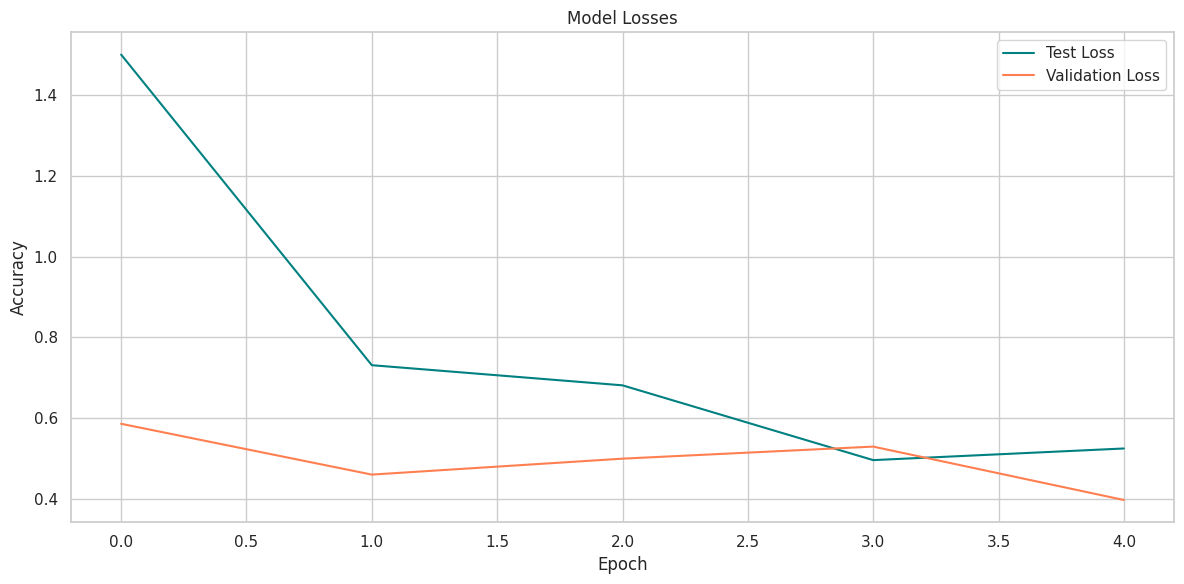

In [53]:
# Plot size
plt.figure(figsize = (12,6))

plt.plot(history.history['loss'], c = 'teal')
plt.plot(history.history['val_loss'], c = 'coral')
plt.title('Model Losses')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test Loss','Validation Loss'])

plt.tight_layout()

plt.savefig('/content/drive/My Drive/ravelry_project/plots/vgg16_loss', dpi = 192);

In [26]:
# Model Accuracy?
model.evaluate(test_gen)

30/30 [==============================] - 49s 2s/step - loss: 0.3971 - acc: 0.8667


[0.39708030223846436, 0.8666666746139526]

In [29]:
y_pred = np.argmax(model.predict(test_gen), axis = 1)


30/30 [==============================] - 53s 2s/step


## Mismatched Accuracy Troubleshooting

At this point I see that the prediction accuracy with test photos does not match with the model fit accuracy.  The following are steps to attempt troubleshooting the issue.

In [30]:
test_gen.classes, y_pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2], dtype=int32),
 array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 2, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2, 1, 2, 2, 0, 2,
        1, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1, 2, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 2, 1, 0, 1, 2, 2, 0, 1,
        2, 2]))

In [174]:
classes = test_gen.class_indices
classes

{'hat': 0, 'pullover': 1, 'socks': 2}

In [32]:
report = classification_report(test_gen.classes, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.40      0.40      0.40        30
           1       0.29      0.30      0.30        30
           2       0.28      0.27      0.27        30

    accuracy                           0.32        90
   macro avg       0.32      0.32      0.32        90
weighted avg       0.32      0.32      0.32        90



In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[12 13  5]
 [ 5  9 16]
 [13  9  8]]


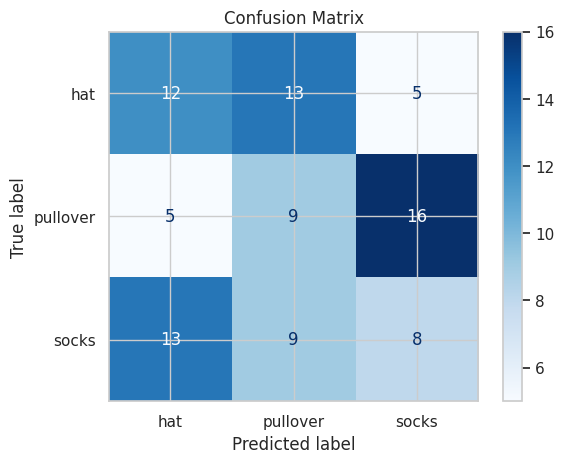

In [52]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Code designed to iterate through misclassified photos.  It will print out the photos along with true and predicted classifications.

In [175]:
wrong_garment_indices = np.where(y_pred != test_gen.classes)[0]

# Iterate through misclassified images and display them
for i in wrong_garment_indices[:10]:
    plt.clf()  # Clears plot - will overwrite otherwise
    try:
        # Retrieve the corresponding batch index and image index within the batch
        batch_index = i // test_gen.batch_size
        image_index = i % test_gen.batch_size

        # Retrieve the corresponding batch from the generator
        test_images, true_labels = test_gen[batch_index]

        # Get the predicted label
        pred = y_pred[i]
        predicted_label = class_names[pred]

        # Get the true label name
        true_label_index = np.argmax(true_labels[image_index])
        true_label_name = class_names[true_label_index]

        # Determine if the prediction is correct
        prediction_status = 'Correct' if pred == true_label_index else 'Incorrect'

        # Display the image
        display_image(test_images[image_index], predicted_label, true_label_name, prediction_status)

        print(f'We thought = {predicted_label}, but really {true_label_name}, Status: {prediction_status}')
    except Exception as e:
        print(f"Error occurred: {e}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## Unseen Predictions

Code designed for reading in an unseen image and outputting the image and predicted outcome.  Unsure if correct due to issues with different accuracy values between model fitting and test predictions.

1/1 [==============================] - 1s 574ms/step


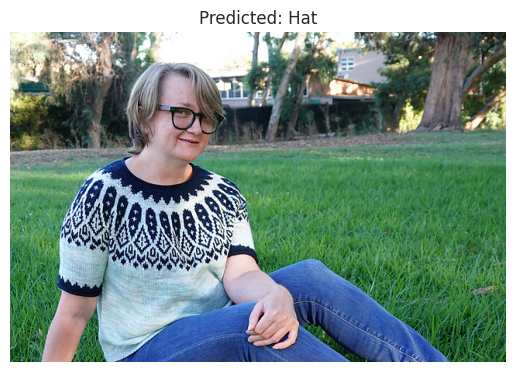

In [117]:
predict_garment(model, unseen_pullover)

1/1 [==============================] - 0s 476ms/step


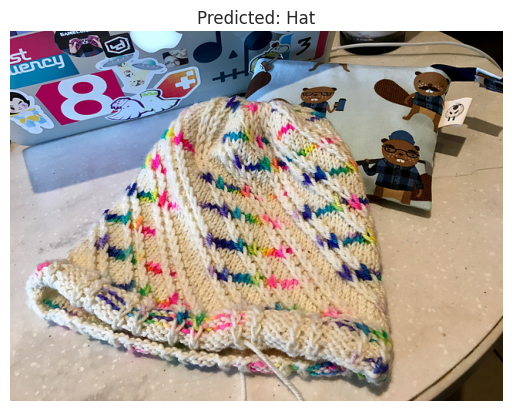

In [119]:
predict_garment(model, unseen_hat)

1/1 [==============================] - 1s 687ms/step


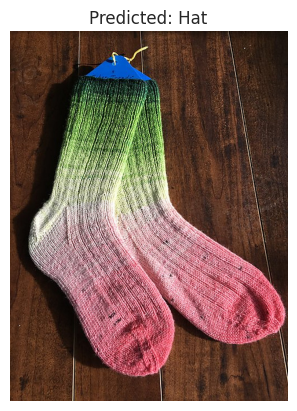

In [120]:
predict_garment(model, unseen_socks)